In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import f1_score, precision_score, recall_score

# Class to handle the entire pipeline
class FraudDetectionModel:
    def __init__(self, data):
        self.data = data
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.models = {
            'Logistic Regression': LogisticRegression(),
            'Decision Tree': DecisionTreeClassifier(),
            'XGBoost': XGBClassifier(),
            'Naive Bayes': GaussianNB(),
        }
        self.results = {}

    def preprocess_data(self):
        # Preprocess the data
        label_encoder = LabelEncoder()

        self.data['type'] = label_encoder.fit_transform(self.data['type'])
        self.data['nameOrig'] = label_encoder.fit_transform(self.data['nameOrig'])
        self.data['nameDest'] = label_encoder.fit_transform(self.data['nameDest'])
        self.data['isFraud'] = label_encoder.fit_transform(self.data['isFraud'])

        # Step 2: Handle missing values (if any)
        self.data.fillna(0, inplace=True)


        self.X = self.data.drop('isFraud', axis=1)  # Features
        self.y = self.data['isFraud']  # Target variable

        # Normalize numerical features
        scaler = StandardScaler()
        self.X = scaler.fit_transform(self.X)

        # Handle imbalanced data with SMOTE
        smote = SMOTE(random_state=42)
        self.X, self.y = smote.fit_resample(self.X, self.y)

        # Class distribution before and after SMOTE
        self.original_y = self.data['isFraud'].value_counts()
        self.smote_y = pd.Series(self.y).value_counts()

    def train_test_split(self):
        # Split the data into training and testing sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.33, random_state=42)

    def train_models(self):
        # Train all models and evaluate
        for name, model in self.models.items():
            print(name)
            model.fit(self.X_train, self.y_train)
            y_pred = model.predict(self.X_test)
            y_proba = model.predict_proba(self.X_test)[:, 1]

            # Evaluate and store results
            accuracy = accuracy_score(self.y_test, y_pred)
            f1 = f1_score(self.y_test, y_pred)
            precision = precision_score(self.y_test, y_pred)
            recall = recall_score(self.y_test, y_pred)
            auc = roc_auc_score(self.y_test, y_proba)

            self.results[name] = {
                'Accuracy': accuracy,
                'F1-Score': f1,
                'Precision': precision,
                'Recall': recall,
                'AUC': auc,
                'Confusion Matrix': confusion_matrix(self.y_test, y_pred)
            }

    def plot_roc_curve(self):
        # Plot ROC curve for all models
        plt.figure(figsize=(10, 6))
        for name, model in self.models.items():
            y_proba = model.predict_proba(self.X_test)[:, 1]
            fpr, tpr, _ = roc_curve(self.y_test, y_proba)
            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(self.y_test, y_proba):.2f})')

        plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve Comparison')
        plt.legend(loc='lower right')
        plt.show()

    def plot_confusion_matrices(self):
        # Plot confusion matrices for all models
        fig, axes = plt.subplots(2, 4, figsize=(20, 12))
        axes = axes.ravel()
        for i, (name, result) in enumerate(self.results.items()):
            sns.heatmap(result['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[i])
            axes[i].set_title(f'{name} Confusion Matrix')
            axes[i].set_xlabel('Predicted')
            axes[i].set_ylabel('True')
        # plt.tight_layout()
        plt.show()

    def plot_comparison_graphs(self):
        # Bar graph to compare model evaluation metrics
        metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall', 'AUC']

        # Prepare data for plotting
        comparison_df = pd.DataFrame(self.results).T[metrics]

        comparison_df.plot(kind='bar', figsize=(12, 8))
        plt.title('Model Comparison: Accuracy, F1-Score, Precision, Recall, AUC')
        plt.ylabel('Score')
        plt.xlabel('Models')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def plot_class_distribution(self):
        # Plot the class distribution before and after SMOTE
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))

        ax[0].pie(self.original_y, labels=self.original_y.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange'])
        ax[0].set_title('Class Distribution Before SMOTE')

        ax[1].pie(self.smote_y, labels=self.smote_y.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange'])
        ax[1].set_title('Class Distribution After SMOTE')

        plt.tight_layout()
        plt.show()

    def display_results(self):
        # Display model evaluation results
        result_df = pd.DataFrame(self.results).T
        print("Model Evaluation Results:")
        print(result_df)

# Load the dataset
url = 'PS_20174392719_1491204439457_log.csv'  # Replace with actual path or Kaggle dataset URL
data = pd.read_csv(url)

# Initialize the FraudDetectionModel class
model = FraudDetectionModel(data)

# Preprocess the data
model.preprocess_data()

# Split into training and testing datasets
model.train_test_split()

# Train models and store evaluation results
model.train_models()


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Logistic Regression
Decision Tree
XGBoost
Naive Bayes


In [2]:
# Display results of the models
model.display_results()

Model Evaluation Results:
                     Accuracy  F1-Score Precision    Recall       AUC  \
Logistic Regression  0.963239  0.963416  0.958713  0.968166  0.992745   
Decision Tree        0.999419  0.999419  0.999179  0.999659  0.999419   
XGBoost              0.998387  0.998388  0.997504  0.999274  0.999968   
Naive Bayes          0.576201  0.268447  0.979915  0.155527  0.915295   

                                         Confusion Matrix  
Logistic Regression  [[2009688, 87424], [66750, 2030047]]  
Decision Tree           [[2095390, 1722], [714, 2096083]]  
XGBoost                [[2091870, 5242], [1522, 2095275]]  
Naive Bayes          [[2090428, 6684], [1770689, 326108]]  


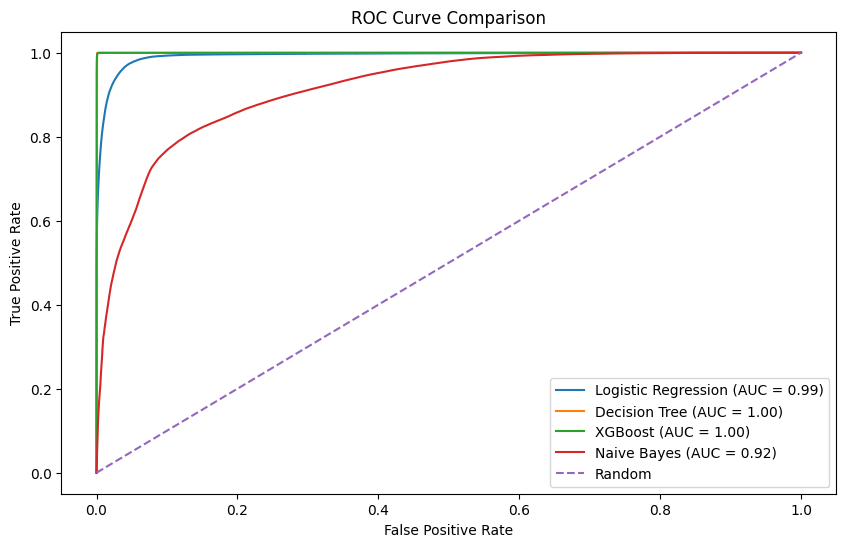

In [3]:
# Plot ROC curves for all models
model.plot_roc_curve()

In [ ]:
# Plot Confusion Matrices for all models
model.plot_confusion_matrices()

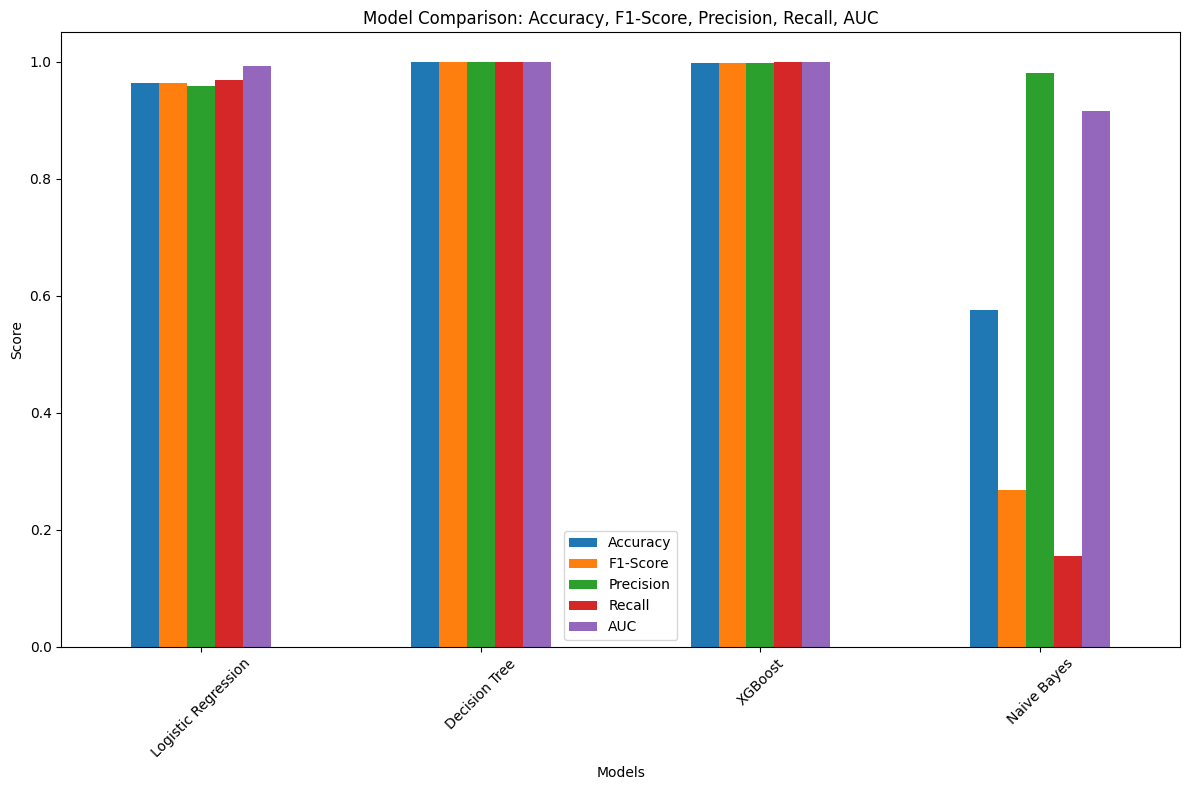

In [5]:
# Plot the comparison of model evaluation metrics
model.plot_comparison_graphs()

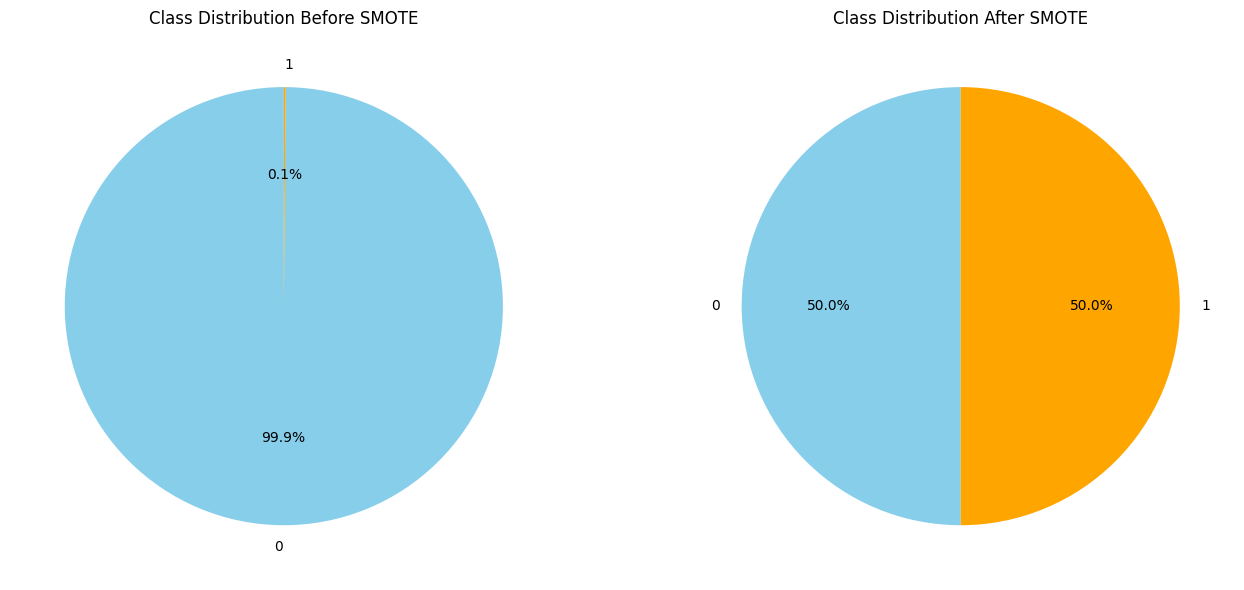

In [6]:
# Plot class distribution comparison before and after SMOTE
model.plot_class_distribution()